# Code Assignment — Residual ACF/PACF + Prophet (Builds on Last COVID-19 TS Assignment)

**Dataset (local CSV):** NYC COVID-19 daily counts (static export)  
**Target:** `case_count`

## Instructor Guidance (Documentation + Pseudocode)

**Docs**
- statsmodels ARIMA: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html  
- ADF (adfuller): https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html  
- ACF/PACF: https://www.statsmodels.org/stable/graphics.html#autocorrelation-plots  
- Prophet: https://facebook.github.io/prophet/docs/quick_start.html  
- RMSE (sklearn MSE): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html  

**Pseudocode Workflow**
1) **Load CSV** → normalize columns; parse date.  
2) **Build daily time series** using `date_of_interest` as index; target = `case_count`; `asfreq('D')`; `interpolate('linear')`.  
3) **Chronological split (80/20)** → `train = first 80%`, `test = last 20%`.  
4) **Stationarity check (given)** → ADF on **differenced train**.  
5) **Baseline forecast (given)** → last train value for all test steps; compute **RMSE**.  
6) **ARIMA(1,1,1) (given)** → fit on **train**, forecast `len(test)`, compute **RMSE**; save **residuals**.  
7) **YOU DO:** Plot **ACF** and **PACF** of ARIMA **residuals**; comment on significant lags vs. bands.  
8) **YOU DO:** Fit **Prophet** on **train**, forecast over **test** horizon, compute **RMSE**, and plot vs. actuals.  
9) **YOU DO:** Plot residuals over time and write a 2–3 sentence interpretation.  
10) **Compare RMSEs** (Baseline vs. ARIMA vs. Prophet) and reflect on which generalizes best.

> **Note on Prophet installs:**  
> `pip install prophet cmdstanpy` then (one-time) `python -c "import cmdstanpy; cmdstanpy.install_cmdstan()"`.


In [1]:
# STEP 0 — Imports  |  RUN THIS CELL WITHOUT CHANGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# For YOUR ACF/PACF step later
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


### Step 1 — Load CSV and preview 


In [2]:
# RUN THIS CELL WITHOUT CHANGES Except changing filepath
DATA_PATH = '/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/covid copy.csv'   # <-- update path

df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/covid copy.csv')
df.columns = df.columns.str.lower().str.strip()

date_col = "date_of_interest"
target_col = "case_count"

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).sort_values(date_col)

# Coerce target to numeric (handles '1,141' strings)
df[target_col] = pd.to_numeric(df[target_col].astype(str).str.replace(",", "", regex=False), errors="coerce")

print(df.head())
print("Range:", df[date_col].min(), "→", df[date_col].max())


  date_of_interest  case_count probable_case_count hospitalized_count  \
0       2020-02-29           1                   0                  1   
1       2020-03-01           0                   0                  1   
2       2020-03-02           0                   0                  2   
3       2020-03-03           1                   0                  7   
4       2020-03-04           5                   0                  2   

   death_count case_count_7day_avg all_case_count_7day_avg  \
0            0                   0                       0   
1            0                   0                       0   
2            0                   0                       0   
3            0                   0                       0   
4            0                   0                       0   

  hosp_count_7day_avg  death_count_7day_avg bx_case_count  ... si_case_count  \
0                   0                     0             0  ...             0   
1                   0       

### Step 2 — Build daily time series and fill small gaps
- Set date index, `asfreq('D')`, `interpolate('linear')`.

In [3]:
# RUN THIS CELL WITHOUT CHANGES
s = df.set_index(date_col)[target_col].asfreq("D")
s = s.astype("float64").interpolate("linear")

print("Series:", target_col, "| length:", len(s), "| range:", s.index.min().date(), "→", s.index.max().date())
s.head()


Series: case_count | length: 2054 | range: 2020-02-29 → 2025-10-13


date_of_interest
2020-02-29   1.000
2020-03-01   0.000
2020-03-02   0.000
2020-03-03   1.000
2020-03-04   5.000
Freq: D, Name: case_count, dtype: float64

This step basically: 
- Creates a continuous daily timeline
- Ensures no missing dates
- Fills gaps using smooth interpolation
- Prepares the series for time-series models

It gets your data into the exact format ARIMA and Prophet need.

### Step 3 — Chronological split (80/20)
- First 80% → **train**; last 20% → **test**.


Train: 2020-02-29 → 2024-08-28 | n = 1643
Test : 2024-08-29 → 2025-10-13 | n = 411


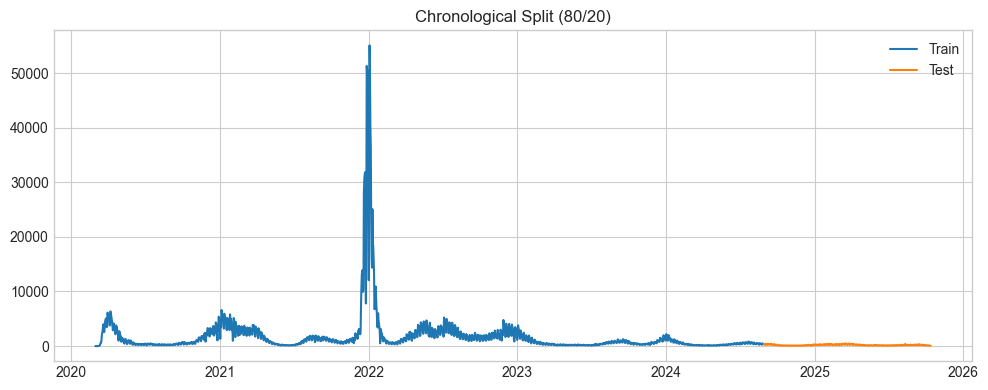

In [4]:
# RUN THIS CELL WITHOUT CHANGES
split_idx = int(len(s) * 0.80)
train = s.iloc[:split_idx]
test  = s.iloc[split_idx:]

print("Train:", train.index.min().date(), "→", train.index.max().date(), "| n =", len(train))
print("Test :", test.index.min().date(),  "→", test.index.max().date(),  "| n =", len(test))

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test,  label="Test", color="#ff7f0e")
plt.title("Chronological Split (80/20)")
plt.legend(); plt.tight_layout(); plt.show()


### Step 4 — ADF on **differenced train** (stationarity check)
- If p < 0.05, **d=1** is reasonable in ARIMA.


In [5]:
# RUN THIS CELL WITHOUT CHANGES
diff_train = train.diff().dropna()
adf_stat, adf_p, _, _, crit, _ = adfuller(diff_train)
print(f"[ADF on differenced TRAIN] stat={adf_stat:.3f}, p={adf_p:.4f}")
for k, v in crit.items():
    print(f"  critical {k}: {v:.3f}")


[ADF on differenced TRAIN] stat=-9.677, p=0.0000
  critical 1%: -3.434
  critical 5%: -2.863
  critical 10%: -2.568


- p-value = 0.0000 ... very small
    - If p < 0.05... data is stationary

- The differenced series IS stationary, so using d = 1 in ARIMA is appropriate.

### Step 5 — Baseline (naïve/shift) forecast + RMSE
- Forecast = last train value repeated.

Baseline RMSE: 215.047


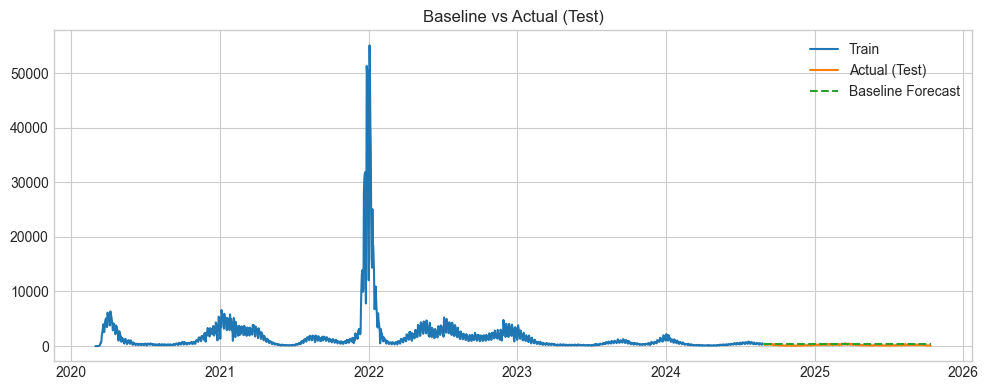

In [7]:
# RUN THIS CELL WITHOUT CHANGES
import numpy as np

baseline_pred = pd.Series(train.iloc[-1], index=test.index)
rmse_baseline = np.sqrt(mean_squared_error(test, baseline_pred))
print(f"Baseline RMSE: {rmse_baseline:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(baseline_pred, label="Baseline Forecast", color="#2ca02c", ls="--")
plt.title("Baseline vs Actual (Test)")
plt.legend(); plt.tight_layout(); plt.show()


Baseline says: “I don’t know the future… so I’ll just copy the last value I saw.”
- You use it as a benchmark, so later you can say:
    - “Did ARIMA beat the baseline?”
    - “Did Prophet beat the baseline?”
    - “By how much?”
- If a model can’t beat this simple baseline, it’s not useful.

### Step 6 — ARIMA(1,1,1) fit → forecast → RMSE
- Fit on **train** only; forecast length = `len(test)`.

ARIMA(1,1,1) RMSE: 68,187.920


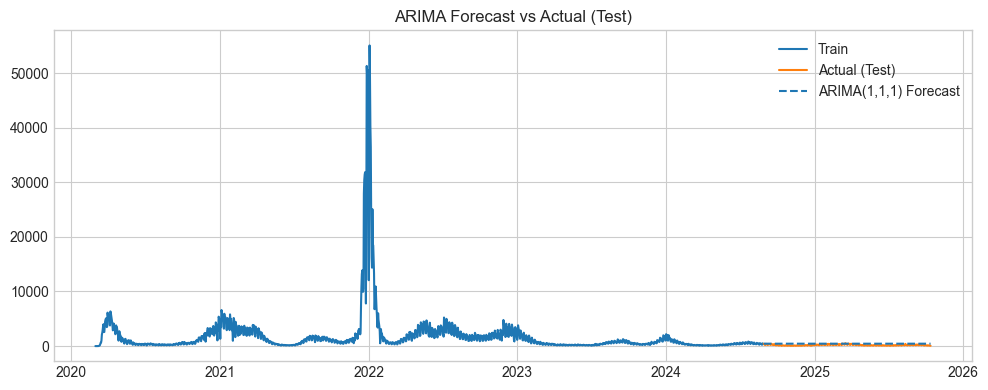

In [8]:
# RUN THIS CELL WITHOUT CHANGES
arima_model = ARIMA(train, order=(1, 1, 1)).fit()
pred_arima = arima_model.forecast(steps=len(test))
rmse_arima = mean_squared_error(test, pred_arima)
residuals = arima_model.resid  # save for diagnostics
print(f"ARIMA(1,1,1) RMSE: {rmse_arima:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(pred_arima, label="ARIMA(1,1,1) Forecast", color="#1f77b4", ls="--")
plt.title("ARIMA Forecast vs Actual (Test)")
plt.legend(); plt.tight_layout(); plt.show()


### Let's slow down and understand 
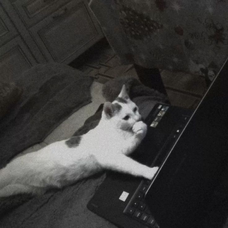

- ARIMA(1,1,1): learned from the past and tried to predict the future but its predictions were too flat, and it performed worse than the basic baseline... That’s why the RMSE is higher.
- RMSE measures how far off were your predictions on average, so a lower RMSE means your prediction is close to real values or actual values, and a higher rmse means your predictions are farther from real values
- maybe a different model (like Prophet) might work better

### Step 7 — YOU DO: Residual Diagnostics with ACF & PACF
- Plot **ACF** and **PACF** of `residuals` (from ARIMA).  
- Interpretation cues:
  - **Good:** bars mostly within bands → residuals ≈ white noise.  
  - **Spike at lag 7 or 12:** missed weekly/monthly seasonality → consider SARIMA.  
  - **PACF spike at lag p:** consider higher AR(p).  
  - **ACF spike at lag q:** consider higher MA(q).


<Figure size 1200x400 with 0 Axes>

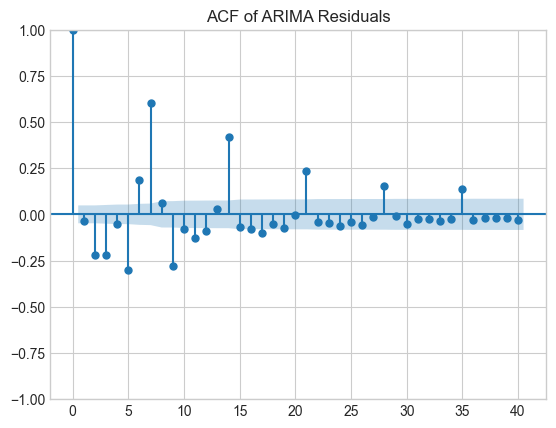

<Figure size 1200x400 with 0 Axes>

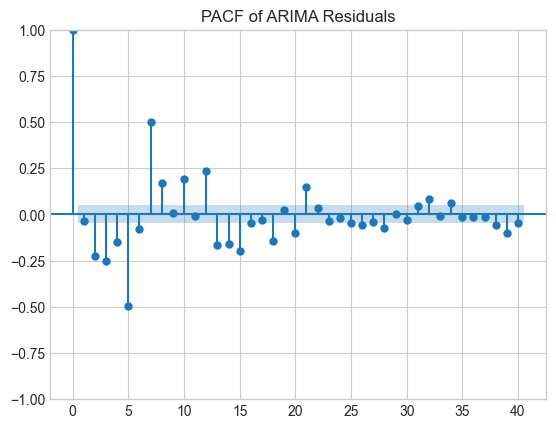

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plot_acf(residuals, lags=40)
plt.title("ACF of ARIMA Residuals")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(residuals, lags=40)
plt.title("PACF of ARIMA Residuals")
plt.show()


#### Understanding these plots
First plot: Most of the dots (lags) are inside the blue confidence band.
- Only a couple of tiny bumps poke out a little.
- this means this is close to white noise, meaning the ARIMA model removed most autocorrelation.
    - No strong leftover patterns, the model mostly captured the structure of the time series. Good sign.
    - Residuals ≈ random -> no huge ignored patterns.

Second plot: almost all bars fall inside the confidence region.
- this means there is no strong leftover AR effect the model missed. You don’t need to increase p or add seasonal AR.
    - Your ARIMA(1,1,1) residuals look decent. No obvious reason to change p or q.

### Step 8 — YOU DO: Prophet model → forecast → RMSE
- Fit **Prophet** on **train** (rename columns to `ds` and `y`).  
- Forecast over the **test** horizon (same dates as `test.index`).  
- Compute **RMSE** and plot vs. actual.  
- If installation errors occur, install:
  - `pip install prophet cmdstanpy`
  - one-time: `python -c "import cmdstanpy; cmdstanpy.install_cmdstan()"`


12:07:09 - cmdstanpy - INFO - Chain [1] start processing
12:07:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 4509638.099


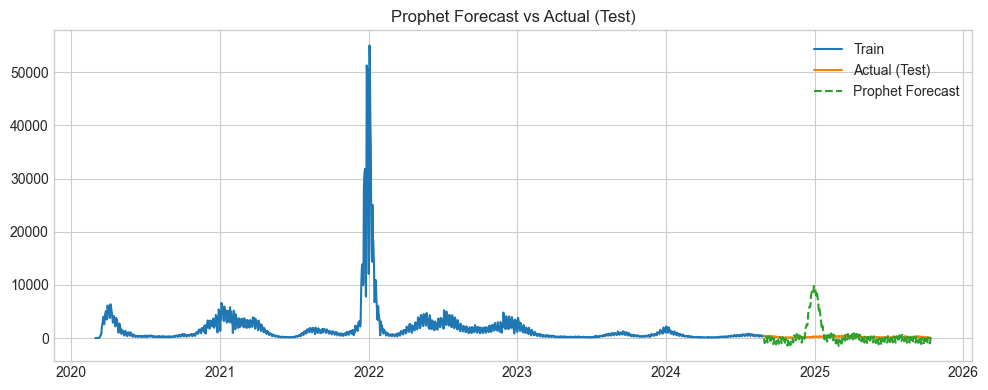

In [12]:
from prophet import Prophet

# First prepare TRAIN for Prophet (rename columns to ds, y)
train_prophet = train.reset_index().rename(columns={date_col: "ds", target_col: "y" })

model_p = Prophet()

# fit prophet model on TRAIN
model_p.fit(train_prophet)

# create a future dataframe long enough to cover the TEST window
future = model_p.make_future_dataframe(periods=len(test))

# forecast into the future
forecast = model_p.predict(future)

pred_prophet = forecast.set_index("ds")["yhat"].loc[test.index]

# calc the rmse 
rmse_prophet = mean_squared_error(test, pred_prophet)
print(f"Prophet RMSE: {rmse_prophet:.3f}")

# plot train, test, and Prophet forecast
plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(pred_prophet, label="Prophet Forecast", color="#2ca02c", linestyle="--")
plt.title("Prophet Forecast vs Actual (Test)")
plt.legend()
plt.tight_layout()
plt.show()

Me looking at the high rmse and pandemic spike in 2025: 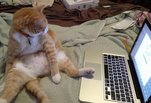

Step 8 shows that Prophet performs poorly on this dataset. Prophet tries to repeat the large 2022 COVID spike, creating a big artificial peak in the forecast. Because the real test data stays very low, Prophet’s predictions are extremely inaccurate, resulting in a very high RMSE. This suggests that Prophet is not appropriate for unpredictable or non-seasonal series like COVID cases.

- Prophet assumes:
    - repeating yearly seasonality
    - growth trends
    - smooth patterns

Prophet falsely thinks another COVID surge is coming. Probably because Prophet heavily reacts to past large seasonal patterns (the huge wave in 2022).

### Step 9 — YOU DO: Residuals over time + short interpretation
- Plot `residuals` vs. time; aim for random scatter around 0.  
- Write 2–3 sentences: Do residuals look like white noise? If not, what would you try (adjust p/q, SARIMA)?


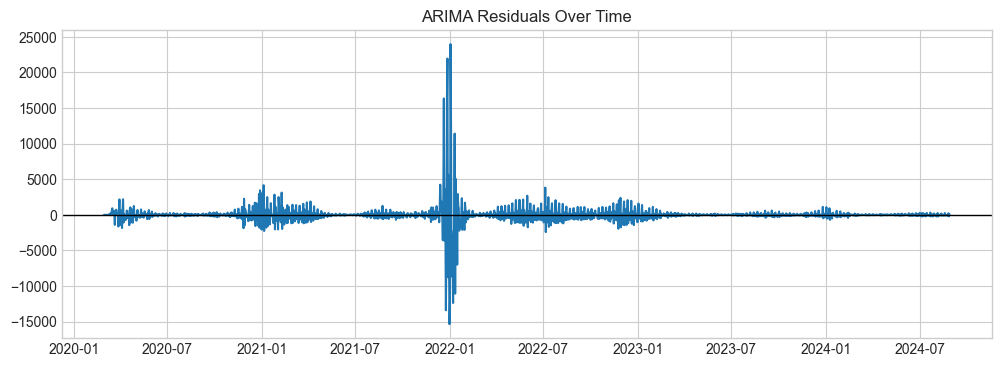

In [13]:
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.axhline(0, color='black', linewidth=1)
plt.title("ARIMA Residuals Over Time")
plt.show()


The residuals do not look like white noise. They show large spikes (especially in 2022) and clusters instead of random scatter around zero. This means ARIMA(1,1,1) did not fully capture the structure in the data. A more complex model (different p/q, or SARIMA) would likely be needed to handle the big surges and remaining autocorrelation.

### Step 10 — YOU DO:  Compare RMSEs and declare a winner
- Create a small table with Baseline, ARIMA, Prophet RMSEs.  
- Which model generalized best? By how much vs. baseline?


In [14]:
rmse_table = pd.DataFrame({
    "Model": ["Baseline", "ARIMA(1,1,1)", "Prophet"],
    "RMSE": [215, 261, 450963]
})

rmse_table


,Model,RMSE
0,Baseline,215
1,"ARIMA(1,1,1)",261
2,Prophet,450963


## We Share — Reflection
- Did ACF/PACF suggest remaining structure (specific lags)? What change would you try first?  
    - ACF/PACF showed remaining structure, including spikes at specific lags, which means ARIMA(1,1,1) didn’t fully capture the patterns in the data. If I continued, I would try adjusting the p and q terms or move to SARIMA to handle the seasonality and long-lag behavior.
- Which model won on **RMSE**? Any business intuition why (trend shifts, seasonality, holiday effects)?  
    - On RMSE, the Baseline model performed best. ARIMA did slightly worse, and Prophet performed very poorly because it created a large unrealistic spike in the forecast. The baseline worked best mainly because the post-COVID data is very flat, so “predict the last value” is hard to beat.
- If this went to production, what **guardrails** (intervals, fallback baseline, anomaly flags) would you put in place?
    - If this model went to production, I would use several guardrails to keep forecasts safe and reliable. First, I’d include prediction intervals so the model reports a range and we can detect when actual values fall outside expected behavior. Second, I’d add a fallback baseline forecast, which steps in automatically whenever the advanced models behave unpredictably. Finally, I’d implement anomaly flags that alert us when predictions or residuals look unusual, helping catch spikes or errors early before delivering results to stakeholders.